## <b>Import TensorFlow and other libraries</b>

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os # import os for various files and directory related operations
import PIL # import python imaging library
import tensorflow as tf
import pathlib # interact with file paths and file systems
# keras is a high-level neural networks API for
# training, building and deploying deep learning models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### <b>Download and explore the dataset</b>

About the dataset: The grapevine leaf dataset consists of healthy leaves and unhealthy leaves affected by the Esca disease. There are 500 images within dataset. The dataset has the following folders:

/Ak<br>
/Nazli<br>
/Dimnit<br>
/Buzgulu<br>
/Ala_Idris<br><br>

The dataset is downloaded from the https://www.muratkoklu.com/en/publications/ website.


In [2]:
data_dir = pathlib.Path("Grapevine_Leaves_Image_Dataset")
# Get a list of all items (files and directories) in the directory
all_items = os.listdir(data_dir)

# Filter out only the directories
folders = [item for item in all_items if os.path.isdir(os.path.join(data_dir, item))]

# Print the list of folders
print("Folders in the directory:")
for folder in folders:
    print(folder)

Folders in the directory:
Dimnit
Ak
Ala_Idris
Nazli
Buzgulu


After downloading the dataset there are 500 images within dataset.

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

500


Here are some leaves.

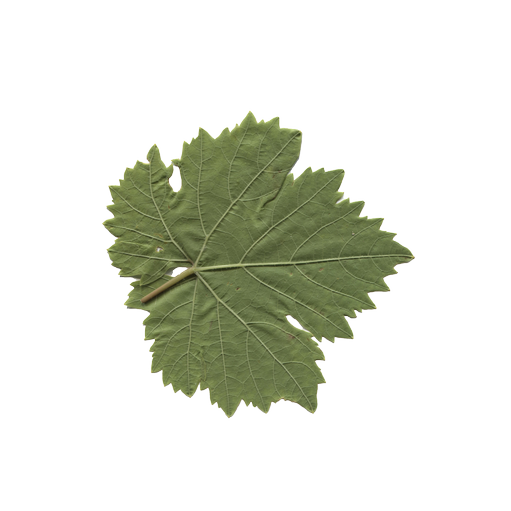

In [4]:
# View one leaf
ak_grape = list(data_dir.glob('Ak/*'))
PIL.Image.open(str(ak_grape[0]))

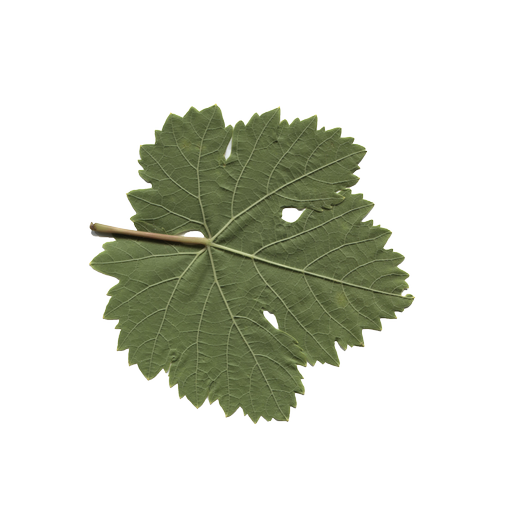

In [5]:
# View second leaf
ak_grape = list(data_dir.glob('Ak/*'))
PIL.Image.open(str(ak_grape[1]))

## <b>Load using keras.preprocessing</b>

Load the images using off the disk using "image_dataset_from_directory" utility.

### <b>Create a dataset</b>

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 511
img_width = 511

Let split dataset. 80% for training and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 500 files belonging to 5 classes.
Using 400 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 500 files belonging to 5 classes.
Using 100 files for validation.


You can find the class names in the class_names attributes in dataset. These correspond to the directory names in alphabetical order.

In [9]:
class_names = train_ds.class_names
print(class_names)

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']


<b>Visualize the data</b>

Here are first 9 images from the training dataset.

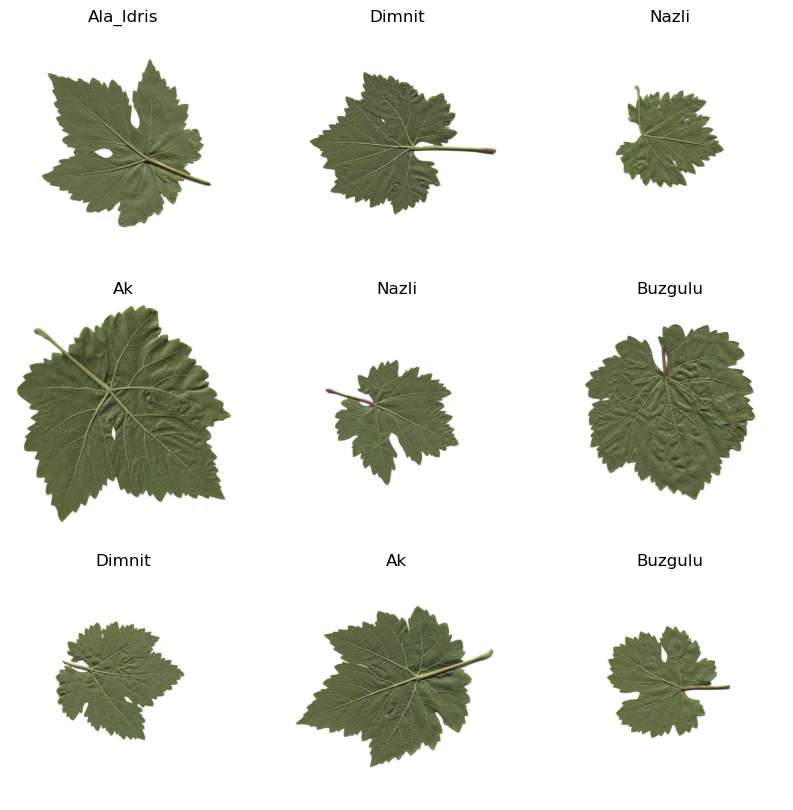

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Manually iterate over the dataset.

In [11]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 511, 511, 3)
(32,)


The image_batch is a tensor of shape (32, 180, 180, 3). This is a batch of 32 images of shape (180, 180, 3) (the last dimension refers to the color channels RGB). The label_batch is a tensor of shape (32,) that corresponds to the 32 images.
You call the .numpy() on image_batch and label_batch tensors to conver them to numpy.narray.

<b>Configure the dataset for performance</b>

Use the buffered prefetching so you can yield data from disk with having I/O becoming blocking/issues.Two important methods to use:

Dataset.cache(): method keeps the training data in memory after loaded off disk after the first epoch. This will ensure dataset doesnot become bottleneck while training model.

Dataset.prefetch(): overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<B>Standardize the data</b>

The RGB channels values are from [0, 255] range. This is not ideal for neural network, should have small input. Standarzie values to be in [0, 1] range using Rescaling layer.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04705883 1.0


<b>Create the model</b>

The model consists of three convolution layers with a max pool layer in each of them. There is a fully connected layer with 128 neurons on top of it that is activated by the relu activation function.

In [15]:
num_classes = 5

model = Sequential([
    # Rescale pixel values between 0 and 1
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Define a convolution with 16 filters and 3X3 kernel
    #layers.Conv2D(16, 3, padding='same', activation='relu'),
    # Max pooling layer to reduce spatial dimension
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Flatten layer to convert the #D output to 1D output for fully connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

<b>Compile model</b>

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<b>Model Summary</b>

View all the layers of the network using model's summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 511, 511, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 511, 511, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 255, 255, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      1

<b>Train the model</b>

In [18]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/5
13/13 [==============================] - 14s 1s/step - loss: 8.5775 - accuracy: 0.1925 - val_loss: 1.6474 - val_accuracy: 0.2200
Epoch 2/5
13/13 [==============================] - 14s 1s/step - loss: 1.6178 - accuracy: 0.2125 - val_loss: 1.6048 - val_accuracy: 0.1600
Epoch 3/5
13/13 [==============================] - 13s 1s/step - loss: 1.5960 - accuracy: 0.3100 - val_loss: 1.5920 - val_accuracy: 0.1700
Epoch 4/5
13/13 [==============================] - 14s 1s/step - loss: 1.5325 - accuracy: 0.4250 - val_loss: 1.5661 - val_accuracy: 0.3200
Epoch 5/5
13/13 [==============================] - 13s 1s/step - loss: 1.3902 - accuracy: 0.5350 - val_loss: 1.5326 - val_accuracy: 0.3100


<b>Visualize the results</b>

Create plots for accraucy on training and validation sets

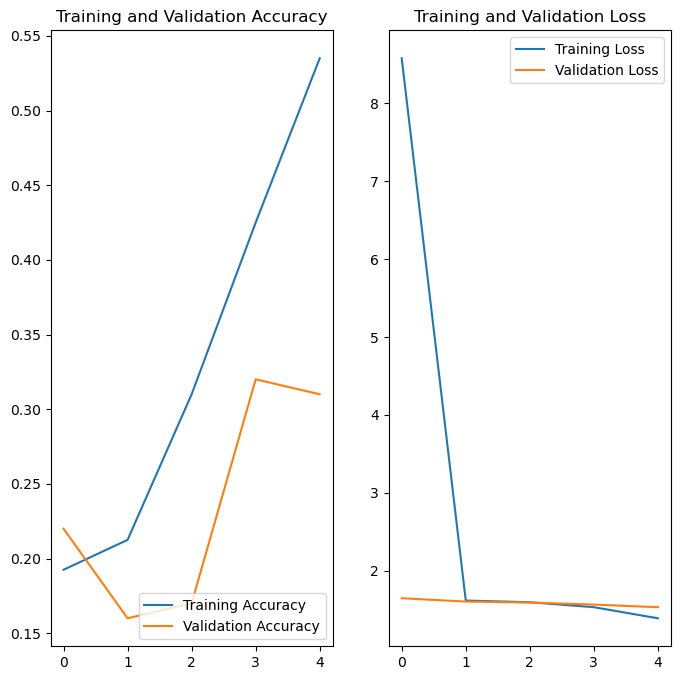

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
predictions = model.predict(val_ds)

4/4 [==============================] - 1s 164ms/step


In [21]:
test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)

4/4 [==============================] - 1s 165ms/step - loss: 1.5326 - accuracy: 0.3100
Test accuracy: 0.3100000023841858


As you can see from the plots, the training accuracy and validation accuracy are off by a large margin, and the model has achieved only around 30% accuracy on the validation set.<br><br>


This appears to be a case of overfitting, wherein the data is able to predict with good accuracy on the training data, but not with good accuracy on unseen or validation data.

Let us try to increase the overall performance. Use "data augmentation" and "dropout" techniques.

## <b>Overfitting</b>

</b>Data augmentation</b>

Overfitting occurs when the model is able to generalize on the training model but not able to generalize on validation data (unseen data). Data augmentation generates additional data from the training sample, by augmenting them using random tranformations that yield belivable looking images. This helps expose the model to more aspects of the data and able to generalize better.

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(factor=0.1)#,
    #layers.experimental.preprocessing.RandomBrightness(factor=0.1)
  ])

Lets visualize few imahes with augmented data

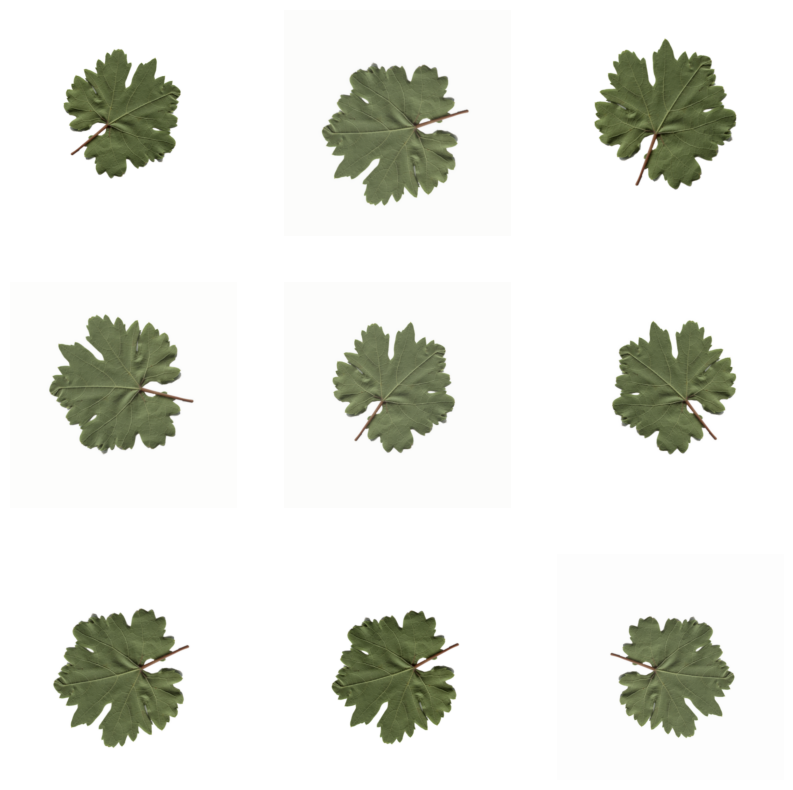

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

<b>Dropout</b>

To help reduce overfitting using dropout, a form of regularization.

When you set 'dropout' to a layer, it randomly drops out (by setting the activation function to 0) a number of outputs units from the layer during the training process. The dropout technique is applied only to the training set. Dropout takes fractional numbers as input such as 0.1, 0.2. This means 10%, 20% of the output units will be randomly set to 0.

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),   
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
# Build the model
#model.build(input_shape=(None, img_height, img_width, 3))

<b>Compile the model</b>

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 511, 511, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 511, 511, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 511, 511, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 255, 255, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 255, 255, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                 

In [28]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 16s 1s/step - loss: 9.0819 - accuracy: 0.2375 - val_loss: 1.6763 - val_accuracy: 0.1800
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 1.6455 - accuracy: 0.1850 - val_loss: 1.6349 - val_accuracy: 0.1800
Epoch 3/10
13/13 [==============================] - 15s 1s/step - loss: 1.6189 - accuracy: 0.1900 - val_loss: 1.6092 - val_accuracy: 0.2000
Epoch 4/10
13/13 [==============================] - 15s 1s/step - loss: 1.6079 - accuracy: 0.2450 - val_loss: 1.6296 - val_accuracy: 0.1600
Epoch 5/10
13/13 [==============================] - 15s 1s/step - loss: 1.6096 - accuracy: 0.2325 - val_loss: 1.6097 - val_accuracy: 0.1600
Epoch 6/10
13/13 [==============================] - 15s 1s/step - loss: 1.6086 - accuracy: 0.2225 - val_loss: 1.6092 - val_accuracy: 0.2100
Epoch 7/10
13/13 [==============================] - 15s 1s/step - loss: 1.6087 - accuracy: 0.2575 - val_loss: 1.6153 - val_accuracy: 0.1900
Epoch 8/10
13/13 [==

<b>Visualize training results</b>

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

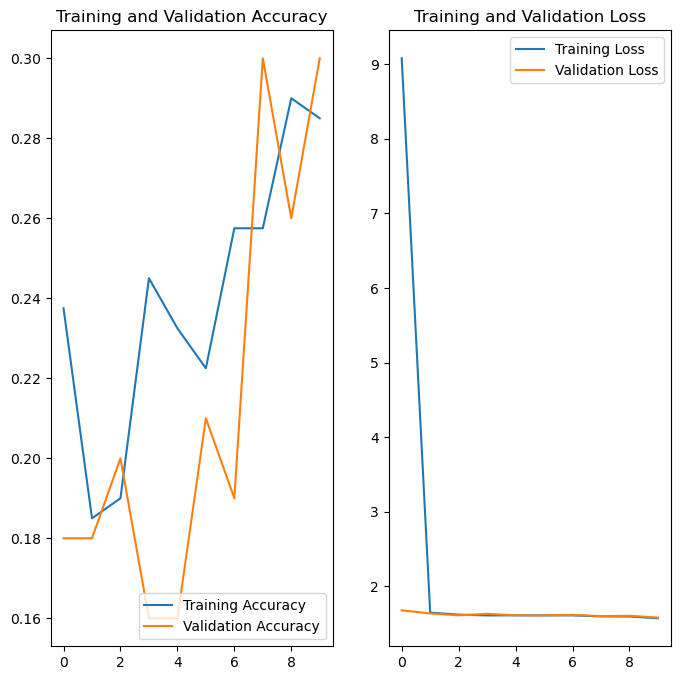

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
predictions = model.predict(val_ds)

4/4 [==============================] - 1s 164ms/step


In [31]:
test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)

4/4 [==============================] - 1s 163ms/step - loss: 1.5789 - accuracy: 0.3000
Test accuracy: 0.30000001192092896


### Step 5. Make predictions on the test data and compare them to the expected categories

The accuracy of the model using GoogleNet is 30%, which is more or less simialr to the model without transfer learning. Various experiments were carried out by altering parameters such as changes in the learning rate, convolution layers, and neural layers. Despite these adjustments, minimal enhancement was observed in test accuracy.
The reason for low accuracy overall could be size of the dataset.